In [78]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.svm import SVR

from sklearn.feature_selection import SelectFpr, SelectFdr, f_regression, mutual_info_regression, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA

from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

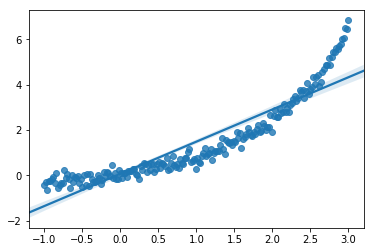

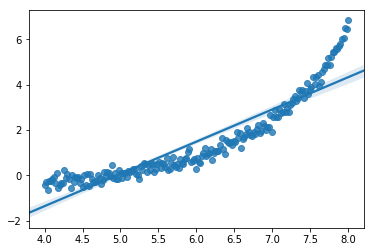

In [42]:
size = 200
x1 = np.linspace(-1, 3, size)
x2 = np.linspace(4, 8, size)

#x1[:40] = x1[:40] + np.random.normal(0, 0.4, size=40)
#x1[40:] = x1[40:] + np.random.normal(0, 0.1, size=20)

#x2[:40] = x2[:40] + np.random.normal(0, 4, size=40)
#x2[40:] = x2[40:] + np.random.normal(0, 10, size=20)

y = 0.3 * np.exp(x1) + 0.2*x2 - 1.2 + np.random.normal(0, 0.2, size=size)
 


sn.regplot(x=x1, y=y)
plt.figure()
sn.regplot(x=x2, y=y)

In [43]:
rg = Ridge()
x1_t = np.reshape(x1, (-1, 1))
x2_t = np.reshape(x2, (-1, 1))
x3_t = np.empty(shape=(size, 30))
x3_t[:,0] = x1_t[:,0]; x3_t[:, 1] = x2_t[:,0]; 

for i in range (2, x3_t.shape[1]):
    x3_t[:,i] = np.random.normal(np.random.uniform(-10, -5), np.random.uniform(1, 4), size=size)

cv1 = -cross_val_score(rg, x1_t, y, scoring='neg_mean_absolute_error', cv=5)
cv2 = -cross_val_score(rg, x2_t, y, scoring='neg_mean_absolute_error', cv=5)
cv3 = -cross_val_score(rg, x3_t, y, scoring='neg_mean_absolute_error', cv=5)

print(cv1.mean(), cv1.std())
print(cv2.mean(), cv2.std())
print(cv3.mean(), cv3.std())

1.0525216031080435 0.5880238125404329
1.0525216031080442 0.5880238125404333
1.0650313129660935 0.5489681936467226


Text(0.5, 0, 'Training set size')

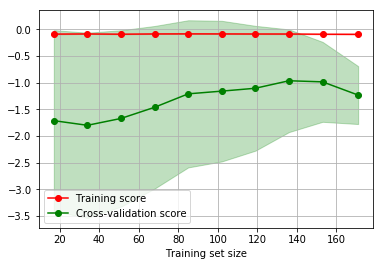

In [44]:
train_sizes, train_scores, test_scores = learning_curve(
    SVR(kernel='poly', gamma='auto'), x3_t, y, train_sizes=np.arange(0.1, 1.1, 0.1), cv=7,
scoring="neg_mean_absolute_error")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.25,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Training set size")

In [45]:
columns = ['f_' + str(i) for i in range(1, x3_t.shape[1]+1)]
df = pd.DataFrame(x3_t, columns=columns)

In [46]:
selector = SelectFdr(f_regression, alpha=0.05)
selector.fit(df, y)
# Get columns to keep
cols = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
df_new = df.iloc[:, cols]
df_new.head(5)

,f_1,f_2
0,-1.000000,4.000000
1,-0.979899,4.020101
2,-0.959799,4.040201
3,-0.939698,4.060302
4,-0.919598,4.080402


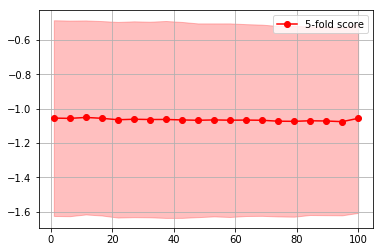

In [7]:
clf = Pipeline([('anova', SelectPercentile(mutual_info_regression)),
                ('svr', Ridge())])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = np.array([])
score_stds = np.array([])
percentiles = np.linspace(1, 100, 20)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, x3_t, y, cv=5,
                                 scoring="neg_mean_absolute_error")
    score_means = np.append(score_means, this_scores.mean())
    score_stds = np.append(score_stds, this_scores.std())

plt.figure()
plt.grid()
plt.fill_between(percentiles, score_means - score_stds,
                     score_means + score_stds, alpha=0.25,
                     color="r")
plt.plot(percentiles, score_means, 'o-', color="r",
             label="5-fold score")

plt.legend(loc="best")


In [8]:
score_means

array([-1.0544464 , -1.05602919, -1.05060981, -1.05553744, -1.06404346,
       -1.06114766, -1.06267855, -1.06230541, -1.06504317, -1.06711888,
       -1.06501627, -1.06662071, -1.06592289, -1.06698871, -1.07248726,
       -1.07329188, -1.06992633, -1.07127065, -1.07516683, -1.05585157])

In [9]:
print(np.argsort(score_means))
print(np.argsort(score_stds))

[18 15 14 17 16  9 13 11 12  8 10  4  6  7  5  1 19  3  0  2]
[18 17 16 19 14 15 13 12 10 11  9  2  3  1  6  4  0  5  8  7]


In [10]:
clf.set_params(anova__percentile=6)
clf['anova'].fit(df, y)
# Get columns to keep
cols = clf['anova'].get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
df_new = df.iloc[:, cols]
df_new.head(5)

,f_1,f_2
0,-1.000000,4.000000
1,-0.979899,4.020101
2,-0.959799,4.040201
3,-0.939698,4.060302
4,-0.919598,4.080402


/home/icegas/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/icegas/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameter (CV score=-1.466):
{'pca__n_components': 28, 'svr__alpha': 21.54434690031882}


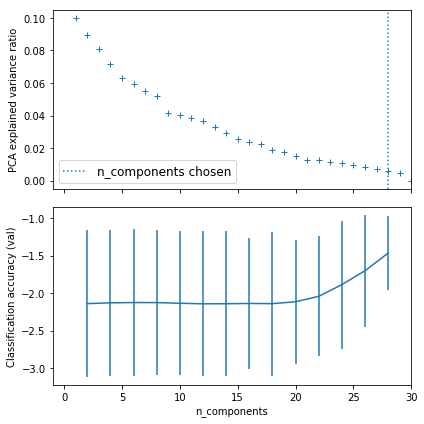

In [11]:
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('svr', Ridge())])

param_grid = {
    'pca__n_components': np.arange(2, 30, 2),
    'svr__alpha': np.logspace(-4, 4, 4),
    #'svr__kernel' : ['rbf']
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,  scoring="neg_mean_absolute_error")
search.fit(x3_t, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(x3_t)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 30)

plt.tight_layout()
plt.show()

In [85]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            
            q25 = np.quantile(scores, 0.25)
            q75 = np.quantile(scores, 0.75)
            iqr = np.subtract(*np.percentile(scores, [75, 25]))
            
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                 'q25' : q25,
                 'q75' : q75,
                 'q50' : np.quantile(scores, 0.5),
                 'q75_iqr' : q75 + iqr,
                 'q25_iqr' : q25 - iqr
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'mean_score', 'std_score', 'max_score', 'min_score', 'q50', 'q25', 'q75',
                   'q75_iqr', 'q25_iqr']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [79]:
models1 = {
    'KernelRidge' : KernelRidge(),
    'SVR': SVR(), 
    'Poly_GP' : Pipeline(steps=[('poly', PolynomialFeatures()), ('GP', GaussianProcessRegressor())]),
    'LightGbm' : LGBMRegressor(),
    'XGB' : XGBRegressor(),
    'MLP' : MLPRegressor()

   
}

params1 = {
    
   'SVR': [
        {'kernel': ['linear'], 'C': np.logspace(-4, 4, 4)},
        {'kernel': ['rbf'], 'C': np.logspace(-4, 4, 4), 'gamma':  np.logspace(-4, 4, 4)},
        {'kernel': ['poly'], 'C': np.logspace(-4, 4, 4), 'degree': [1]}
    ]
    
    ,
    
    'KernelRidge': [
        {'kernel': ['linear'], 'alpha': np.logspace(-4, 4, 4)},
        {'kernel': ['rbf'], 'alpha': np.logspace(-4, 4, 4), 'gamma':  np.logspace(-4, 4, 4)},
        {'kernel': ['poly'], 'alpha': np.logspace(-4, 4, 4), 'degree': [1]}
    ]
    
    ,
    
    'Poly_GP': [
        
    {'GP__kernel': [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))], 
     'GP__alpha': np.logspace(-4, 4, 4), 'poly__degree' : [1] },
    {'GP__kernel': [1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1) ] , 
     'GP__alpha': np.logspace(-4, 4, 4), 'poly__degree' : [1] },
        
        
    {'GP__kernel': [1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)], 'GP__alpha': np.logspace(-4, 4, 4), 'poly__degree' : [1]}

    ]
    
    ,
    
    'LightGbm' : [
        
        #'dart', 'goss', 'rf'
        { 'boosting_type' : ['gbdt', 'dart', 'goss'],  #'num_leaves' : np.arange(2, 20, 5), 
         'max_depth' : np.arange(1, 20, 4),
        'learning_rate' : [1e-1, 1e-2, 1e-3], 'n_estimators ' : np.arange(20, 120, 60),
         'reg_lambda' : np.linspace(0, 1, 4), 
         'objective' : ['regression', 'regression_l1', 'huber', 
                      'fair', 'quantile', 'mape'] }
        
    ]
    
    ,
    
    'XGB' : [
        
        #'gbtree', 'gblinear', 'dart'
        {'booster' : ['dart'], 'eta' : [1e-1, 1e-2, 1e-3],
        'max_depth' : np.arange(1, 20, 4), 'max_leaves' : np.arange(2, 20, 5),
        'n_estimators ' : np.arange(20, 120, 60), 
         
         #dart booster parameters
         'sample_type' : ['uniform', 'weighted'], 'normalize_type' : ['tree', 'forest'],
        'rate_drop' : np.arange(0, 0.7, 0.1) },
        
        #'gblinear'
        {'booster' : ['gblinear'], 'eta' : [1e-1, 1e-2, 1e-3],
        'max_depth' : np.arange(1, 20, 4), 'max_leaves' : np.arange(2, 20, 5),
        'n_estimators ' : np.arange(20, 120, 60), 
         
         #gblinear booster parameters
         'updater' : ['coord_descent'], 
         'feature_selector' : ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty']},
        
        {'booster' : ['gbtree'], 'eta' : [1e-1, 1e-2, 1e-3],
        'max_depth' : np.arange(1, 20, 4), 'max_leaves' : np.arange(2, 20, 5),
        'n_estimators ' : np.arange(20, 120, 60) }
        
    ]
    
    ,
    
    'MLP' : [
        
        { 'activation' : ['identity', 'logistic', 'tanh', 'relu'] ,
          'solver' : ['adam', 'lbfgs'], 
          'hidden_layer_sizes' : np.arange(10, 500, 10)},
          
    ]
    
    
}

gs = EstimatorSelectionHelper(models1, params1)
gs.fit(df_new, y, scoring='neg_mean_absolute_error', n_jobs=-1)

Running GridSearchCV for LightGbm.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


Running GridSearchCV for Poly_GP.
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.6s finished


Running GridSearchCV for MLP.
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.7s finished


Running GridSearchCV for XGB.
Fitting 5 folds for each of 4080 candidates, totalling 20400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 6060 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9660 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 14060 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 19260 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 20400 out of 20400 | elapsed:  4.3min finished


Running GridSearchCV for SVR.
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   16.9s finished


Running GridSearchCV for KernelRidge.
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.0s finished


In [81]:
df = gs.score_summary()

LightGbm
Poly_GP
KernelRidge
XGB
SVR
MLP


/home/icegas/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [84]:
df.iloc[0,:]

estimator                   MLP
mean_score            -0.192398
std_score             0.0518858
max_score              -0.14684
min_score             -0.290548
q50                   -0.175899
q25                   -0.194702
q75                   -0.154002
C                           NaN
GP__alpha                   NaN
GP__kernel                  NaN
activation             logistic
alpha                       NaN
booster                     NaN
boosting_type               NaN
degree                      NaN
eta                         NaN
feature_selector            NaN
gamma                       NaN
hidden_layer_sizes          100
kernel                      NaN
max_depth                   NaN
max_leaves                  NaN
n_estimators                NaN
normalize_type              NaN
poly__degree                NaN
q25_iqr               -0.235401
q75_iqr               -0.113303
rate_drop                   NaN
sample_type                 NaN
solver                    lbfgs
updater 